# 探索马拉松比赛成绩数据

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

读取并加载数据

In [2]:
data = pd.read_csv('marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


默认时间列会加载为python字符串格式，通过`dtypes`函数查看类型：

In [30]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

将时间类型转换为pandas的`timedelta`类型，可以在读取文件的时候使用`converters`参数进行转换，也可以读取之后使用`applymap`进行转换，这里使用第一种：

In [3]:
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return pd.Timedelta(hours=h, minutes=m, seconds=s)

In [4]:
# 这里也给出使用applymap函数进行转换的代码
# data = pd.concat([data.iloc[:, :2], data.iloc[:, -2:].applymap(convert_time)], axis=1)

data = pd.read_csv(
    'marathon-data.csv',
    converters={
        'split': convert_time,
        'final': convert_time
    })
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [35]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

为了便于画图，添加两列，将时间转换成秒，这里给出2种方法的代码，要注意的是pandas里面的时间日期类型其实都是以纳秒为单位的64位的浮点数，因此先转换成`np.int64`格式，再除以1E9：

In [48]:
%timeit data['split'].map(lambda x:x.seconds)

844 ms ± 73.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit data['split'].astype(np.int64) / 1E9

600 µs ± 78.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# 使用map要满很多，因为要对每一个元素进行映射，还有读取元素属性的操作会花费大量时间
# data['split_sec'] = data['split'].map(lambda x:x.seconds)
# data['final_sec'] = data['final'].map(lambda x:x.seconds)

data['split_sec'] = data['split'].astype(np.int64) / 1E9
data['final_sec'] = data['final'].astype(np.int64) / 1E9
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


使用`sns.jointplot`作图，对数据初步认识,虚线表示整体时间正好是前半程时间的2倍（即后半程和前半程花的时间一样多），如图可见，大部分人后半程花的时间比前半程要多，及少数人后半程花的时间比前半程反而少：

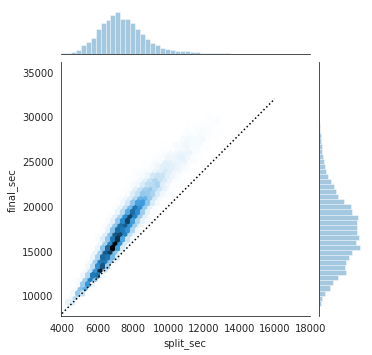

In [65]:
# ax_joint获取中间的axes
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex', height=5)
    g.ax_joint.plot(np.linspace(4000, 16000), np.linspace(8000, 32000), ':k')

创建一列(split_frac)来表示前后半程的差异，衡量比赛选手后半程或前半程加速的程度：

In [6]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


如何前后半程差异系数小于0，则说明这个人后半程花的时间少：

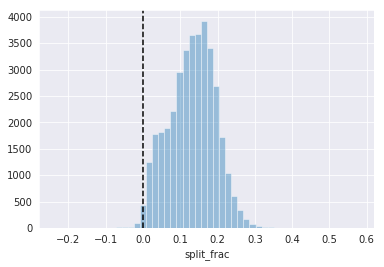

In [86]:
with sns.axes_style('darkgrid'):
    sns.distplot(data['split_frac'], kde=False)
    # 线条样式和颜色只能分开指定，不能使用简写放在一起
    plt.axvline(0, linestyle='--', color='k');

看看有多少人可以做到后半程加速（直接对bool型数组求和）：

In [91]:
sum(data['split_frac'] < 0)

251

看看前后半程差异系数与其它变量的相关性，注意`sns.PairGrid`和`sns.pairplot`的区别，`sns.PairGrid`先对数据进行分组，再通过`map`函数传递一个绘图ui函数，所有子图的类型是一样的。`sns.pairplot`是对`sns.PairGrid`的包装，对角线是频次直方图：

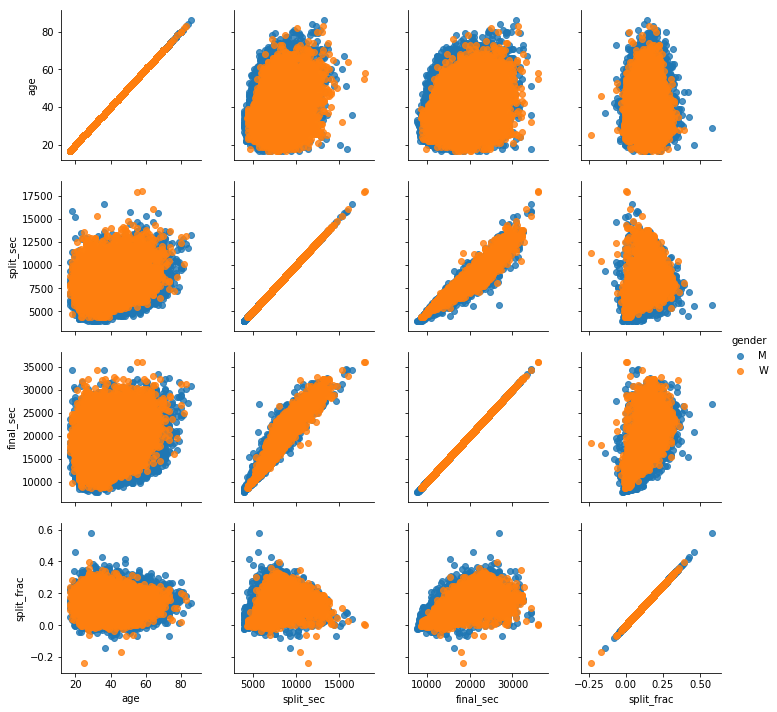

In [95]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'], hue='gender')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

观察上图，后半程加速（split_frac<0）的人往往总的成绩比较好（集中在10000~15000区间），且年龄分布不明显，但是也可以看出主要分布在20~60岁之间，可以针对`split_frac < 0`选取敢兴趣的指标继续钻取做图进行分析。

接下来比较前后半程差异系数的男女选手之间的差异，分别使用kde密度图和violin小提琴图来观察，在前后半程时间接近的选手中，男选手似乎比女选手多很多，且男女都呈现双峰分布：

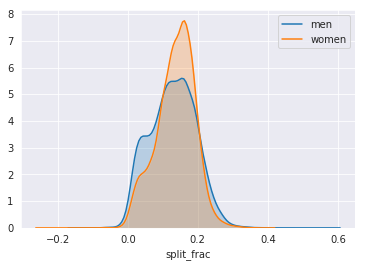

In [19]:
# 两种筛选数据的方式
with sns.axes_style('darkgrid'):
    sns.kdeplot(data[data['gender']=='M']['split_frac'], label='men', shade=True)
    sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
    plt.xlabel('split_frac')

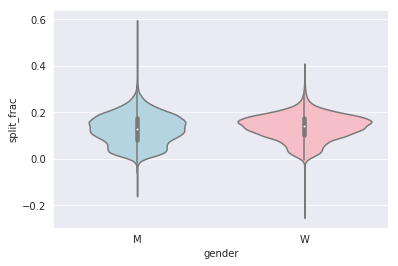

In [22]:
with sns.axes_style('darkgrid'):
    sns.violinplot('gender', 'split_frac', data=data, palette=['lightblue', 'lightpink'])

在数组中创建一个新列，表示每名选手的年龄段：

In [7]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


按照年龄分布绘制和上面一样的小提琴图，查看前后半程差异系数在不同年龄段中男女的差异：

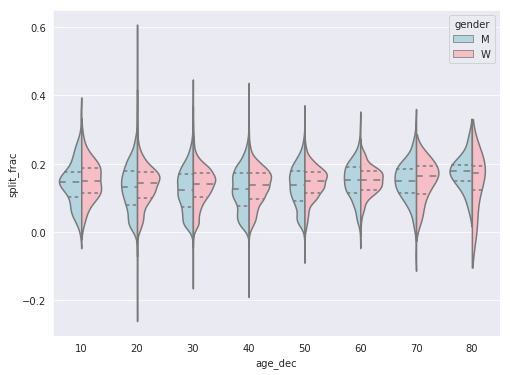

In [8]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(8, 6))
    sns.violinplot(
        "age_dec",
        "split_frac",
        hue="gender",
        data=data,
        split=True, # 如果False,会使用左右对称的小提琴，不同的hue，使用不同的小提琴，如果True，不同的hue会放在一个小提琴里面。
        inner='quartile', # 小提琴内部的显示方式，默认为box，还可以是point,stick,quartile和None
        palette=['lightblue', 'lightpink'])

可见，除了80岁年龄段，在不同的年龄阶段，男性表现比女性要好一些。女性的分布比男性要更集中一些。最后，通过`regplot`查看前后半程的差异系数与最终成绩是否正相关：

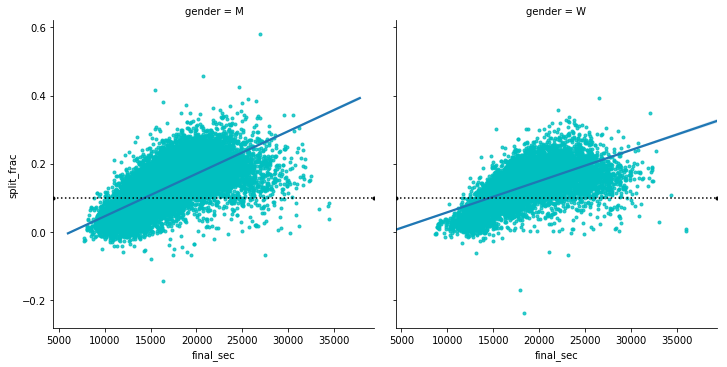

In [22]:
g = sns.lmplot(
    'final_sec',
    'split_frac',
    col='gender',
    data=data,
    markers='.',
    scatter_kws={'color': 'c'})
g.map(plt.axhline, y=0.1, color='k', ls=":")
g.set_xlabels('final_sec')
g.set_ylabels('split_frac');